In [1]:
!pip install -r requirements.txt

In [2]:
!pip install imageio[ffmpeg]

## Setup arguments

This automatically parse arguments as jupyter inputs making it more user friendly :)

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import ipywidgets as widgets
from jupyter_utils import WidgetParser

import time

import torch
from utils import seed_everything


parser = WidgetParser()
parser.add_widget(widgets.IntText(
    description='seed',
    value=1,
    tooltip="seed of the experiment"
))

parser.add_widget(widgets.Checkbox(
    description="torch-deterministic",
    value=True,
    disabled=False,
    indent=False,
    tooltip="if toggled, `torch.backends.cudnn.deterministic=False`"
))

parser.add_widget(widgets.Checkbox(
    description="cuda",
    value=True,
    disabled=False,
    indent=False,
    tooltip="if toggled, cuda will be enabled by default"
))

parser.add_widget(widgets.Checkbox(
    description="capture-video",
    value=False,
    disabled=False,
    indent=False,
    tooltip="whether to capture videos of the agent performances (check out `videos` folder)"
))

parser.add_widget(widgets.Text(
    description="env-id",
    value="CartPole-v1",
    tooltip="the id of the environment"
))

parser.add_widget(widgets.IntText(
    description='total-timesteps',
    value=500000,
    tooltip="total timesteps of the experiments"
))

parser.add_widget(widgets.FloatText(
    description='learning-rate',
    value=2.5e-4,
    tooltip="the learning rate of the optimizer"
))

parser.add_widget(widgets.IntText(
    description='buffer-size',
    value=10000,
    tooltip="the replay memory buffer size"
))

parser.add_widget(widgets.FloatText(
    description='gamma',
    value=0.99,
    tooltip="the discount factor gamma"
))

parser.add_widget(widgets.IntText(
    description='target-network-frequency',
    value=500,
    tooltip="the timesteps it takes to update the target network"
))

parser.add_widget(widgets.IntText(
    description='batch-size',
    value=128,
    tooltip="the batch size of sample from the reply memory"
))

parser.add_widget(widgets.FloatText(
    description='start-e',
    value=1.0,
    tooltip="the starting epsilon for exploration"
))

parser.add_widget(widgets.FloatText(
    description='end-e',
    value=0.05,
    tooltip="the ending epsilon for exploration"
))

parser.add_widget(widgets.FloatText(
    description='exploration-fraction',
    value=0.5,
    tooltip="the fraction of `total-timesteps` it takes from start-e to go end-e"
))

parser.add_widget(widgets.IntText(
    description='learning-starts',
    value=10000,
    tooltip="timestep to start learning"
))

parser.add_widget(widgets.IntText(
    description='train-frequency',
    value=10,
    tooltip="the frequency of training"
))


IntText(value=1, description='seed', tooltip='seed of the experiment')

Checkbox(value=True, description='torch-deterministic', indent=False, tooltip='if toggled, `torch.backends.cud…

Checkbox(value=True, description='cuda', indent=False, tooltip='if toggled, cuda will be enabled by default')

Checkbox(value=False, description='capture-video', indent=False, tooltip='whether to capture videos of the age…

Text(value='CartPole-v1', description='env-id', tooltip='the id of the environment')

IntText(value=500000, description='total-timesteps', tooltip='total timesteps of the experiments')

FloatText(value=0.00025, description='learning-rate', tooltip='the learning rate of the optimizer')

IntText(value=10000, description='buffer-size', tooltip='the replay memory buffer size')

FloatText(value=0.99, description='gamma', tooltip='the discount factor gamma')

IntText(value=500, description='target-network-frequency', tooltip='the timesteps it takes to update the targe…

IntText(value=128, description='batch-size', tooltip='the batch size of sample from the reply memory')

FloatText(value=1.0, description='start-e', tooltip='the starting epsilon for exploration')

FloatText(value=0.05, description='end-e', tooltip='the ending epsilon for exploration')

FloatText(value=0.5, description='exploration-fraction', tooltip='the fraction of `total-timesteps` it takes f…

IntText(value=10000, description='learning-starts', tooltip='timestep to start learning')

IntText(value=10, description='train-frequency', tooltip='the frequency of training')

### Get and parse inputs

In [5]:
args = parser.parse()
print("|param|value|\n|-|-|\n%s" % ("\n".join([f"|{key}|{value}|" for key, value in vars(args).items()])))

|param|value|
|-|-|
|seed|1|
|torch_deterministic|True|
|cuda|True|
|capture_video|False|
|env_id|CartPole-v1|
|total_timesteps|500000|
|learning_rate|0.00025|
|buffer_size|10000|
|gamma|0.99|
|target_network_frequency|500|
|batch_size|128|
|start_e|1.0|
|end_e|0.05|
|exploration_fraction|0.5|
|learning_starts|10000|
|train_frequency|10|


In [6]:
run_name = f"{args.env_id}__dqn__{args.seed}__{int(time.time())}" 
device = torch.device("cuda" if torch.cuda.is_available() and args.cuda else "cpu")
seed_everything(args.seed, args.torch_deterministic)

## Setup environment

Use environment wrappers to record statistics and seed for experiment reproducibility.

In [7]:
import time
import gym
import random

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim




def make_env(env_id, seed, idx, capture_video, run_name):
    def thunk():
        env = gym.make(env_id)
        env = gym.wrappers.RecordEpisodeStatistics(env)
        if capture_video:
            if idx == 0:
                env = gym.wrappers.RecordVideo(env, f"videos/{run_name}")
        env.seed(seed)
        env.action_space.seed(seed)
        env.observation_space.seed(seed)
        return env

    return thunk

### Ensure environement compatibility

This works only with discrete action space.

In [8]:
envs = gym.vector.SyncVectorEnv([make_env(args.env_id, args.seed, 0, args.capture_video, run_name)])
assert isinstance(envs.single_action_space, gym.spaces.Discrete), "only discrete action space is supported"

### Show examples

Show few env steps and the transformation input..

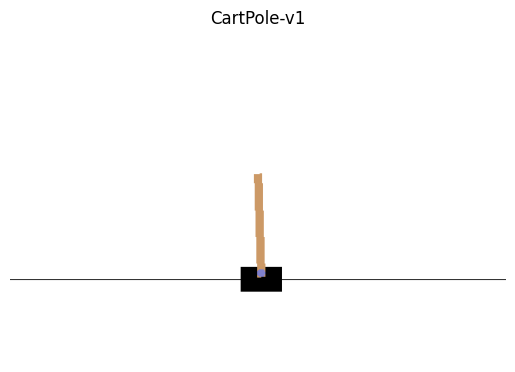

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

tmp_env = make_env(args.env_id, args.seed, 0, False, None)()
ob = tmp_env.reset()

plt.title(args.env_id)
plt.imshow(tmp_env.render("rgb_array"))
plt.axis('off')
plt.show()

In [10]:
action = tmp_env.action_space.sample()
ob, reward, done, info = tmp_env.step(action)
action, ob

(1, array([ 0.03076804,  0.19700098, -0.03151444, -0.33357874], dtype=float32))

## Modeling

### Define Neural Network

The neural network to encode the observations and produce actions.

In [11]:
class QNetwork(nn.Module):
    def __init__(self, env):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(np.array(env.single_observation_space.shape).prod(), 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, env.single_action_space.n),
        )

    def forward(self, x):
        return self.network(x)

### DQN training Wrapper

Setup QNetwork and TargetNetwork along with ReplayBuffer, Optimization and schedules..

In [12]:
def linear_schedule(start_e: float, end_e: float, duration: int, t: int):
    slope = (end_e - start_e) / duration
    return max(slope * t + start_e, end_e)

In [13]:
from dqn import DQN, DQNTrainingWrapper


dqn = DQN(
    model_func=lambda: QNetwork(envs),
    device=device
)

wrapper = DQNTrainingWrapper(
    model = dqn,
    env=envs,
    device=device
)

optimizer = wrapper.get_optimizer(lr=1e-3)

rb = wrapper.get_replay_buffer(
    buffer_size=args.buffer_size,
    optimize_memory_usage=True
)

### DQN training loop

In [14]:
from tqdm.notebook import tqdm_notebook


pbar = tqdm_notebook(range(args.total_timesteps), desc="DiscreteDQN training", unit="step")
obs = envs.reset()
for global_step in pbar:
    epsilon = linear_schedule(
        args.start_e,
        args.end_e,
        args.exploration_fraction * args.total_timesteps,
        global_step
    )

    if random.random() < epsilon:
        actions = np.array([envs.single_action_space.sample()
                            for _ in range(envs.num_envs)])
    else:
        actions = dqn(torch.Tensor(obs).to(device)).cpu().numpy()

    obs, env_infos = wrapper.env_step(obs, actions, rb)

    for info in env_infos:
        if "episode" in info.keys():
            pbar.set_postfix(
                episodic_return=info["episode"]["r"],
                episodic_length=info["episode"]["l"]
            )
            break

    if global_step > args.learning_starts and global_step % args.train_frequency == 0:
        data = rb.sample(args.batch_size)
        q_values, loss = dqn.train_step(data, gamma=args.gamma)

        # if global_step % 100 == 0:
        #     pbar.set_postfix(loss=loss)
        #     pbar.set_postfix(q_values=q_values.mean().item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if global_step % args.target_network_frequency == 0:
            dqn.update_target_network()
envs.close()

DiscreteDQN training:   0%|          | 0/500000 [00:00<?, ?step/s]

## Evaluation

In [22]:
test_env = make_env(args.env_id, args.seed, 0, True, 'dqn_test')()

ob = test_env.reset()
while True:
    action = dqn(torch.Tensor([ob]).to(device)).cpu().numpy()[0]
    ob, reward, done, info = test_env.step(action)
    if done:
        print(f'episodic_return={info["episode"]["r"]}, episodic_length={info["episode"]["l"]}')
        break


episodic_return=500.0, episodic_length=500


In [46]:
import imageio
import os, sys


def mp4_to_gif(mp4_path, gif_path):
    os.makedirs(os.path.dirname(gif_path), exist_ok=True)
    reader = imageio.get_reader(mp4_path)
    fps = reader.get_meta_data()['fps']
    writer = imageio.get_writer(gif_path, fps=fps)
    for i,im in enumerate(reader):
        sys.stdout.write(f"\rWriting frame {i}")
        sys.stdout.flush()
        writer.append_data(im)
    print("\r\nFinalizing...")
    writer.close()
    print("Done.")
mp4_to_gif("videos/dqn_test/rl-video-episode-0.mp4", "images/dqn_test.gif")

Writing frame 500
Finalizing...
Done.


In [47]:
from IPython.display import Image

Image(url= "images/dqn_test.gif", width=500, height=500)